In [145]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")
import kagglehub
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

# Load Dataset

In [3]:
american_electric_power = pd.read_csv("/kaggle/input/hourly-energy-consumption/AEP_hourly.csv")
american_electric_power.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Change to datetime data type

In [4]:
american_electric_power["Datetime"] = pd.to_datetime(american_electric_power["Datetime"])

# Split to date, month and year

In [5]:
american_electric_power["month"] = american_electric_power["Datetime"].dt.month
american_electric_power["year"] = american_electric_power["Datetime"].dt.year

# Apply Standard Scaler

In [6]:
mean_mw = np.mean(american_electric_power['AEP_MW'])
std_mw = np.std(american_electric_power['AEP_MW'])

standard_mw = (american_electric_power['AEP_MW'] - mean_mw) / std_mw
american_electric_power["AEP_MW_SCALED"] = standard_mw

# America Electric Power Statistic

In [7]:
american_electric_power.describe()["AEP_MW"].to_frame().round(2)

,AEP_MW
count,121273.00
mean,15499.51
min,9581.00
25%,13630.00
50%,15310.00
75%,17200.00
max,25695.00
std,2591.40


# Visualization

In [8]:
mean_month = american_electric_power.groupby(["month", "year"])["AEP_MW"].mean().reset_index().round(2)
fig = px.bar(mean_month, x = "month", y = "AEP_MW", animation_frame = "year", color = "AEP_MW", color_discrete_sequence = px.colors.qualitative.Set3)
fig.update_layout(
    title = "Average Estimated Energy Consumption Of Each Month Within A Year",
    xaxis_title = "Month",
    yaxis_title = "America Electric Power (Megawatts)"
)
fig.show()

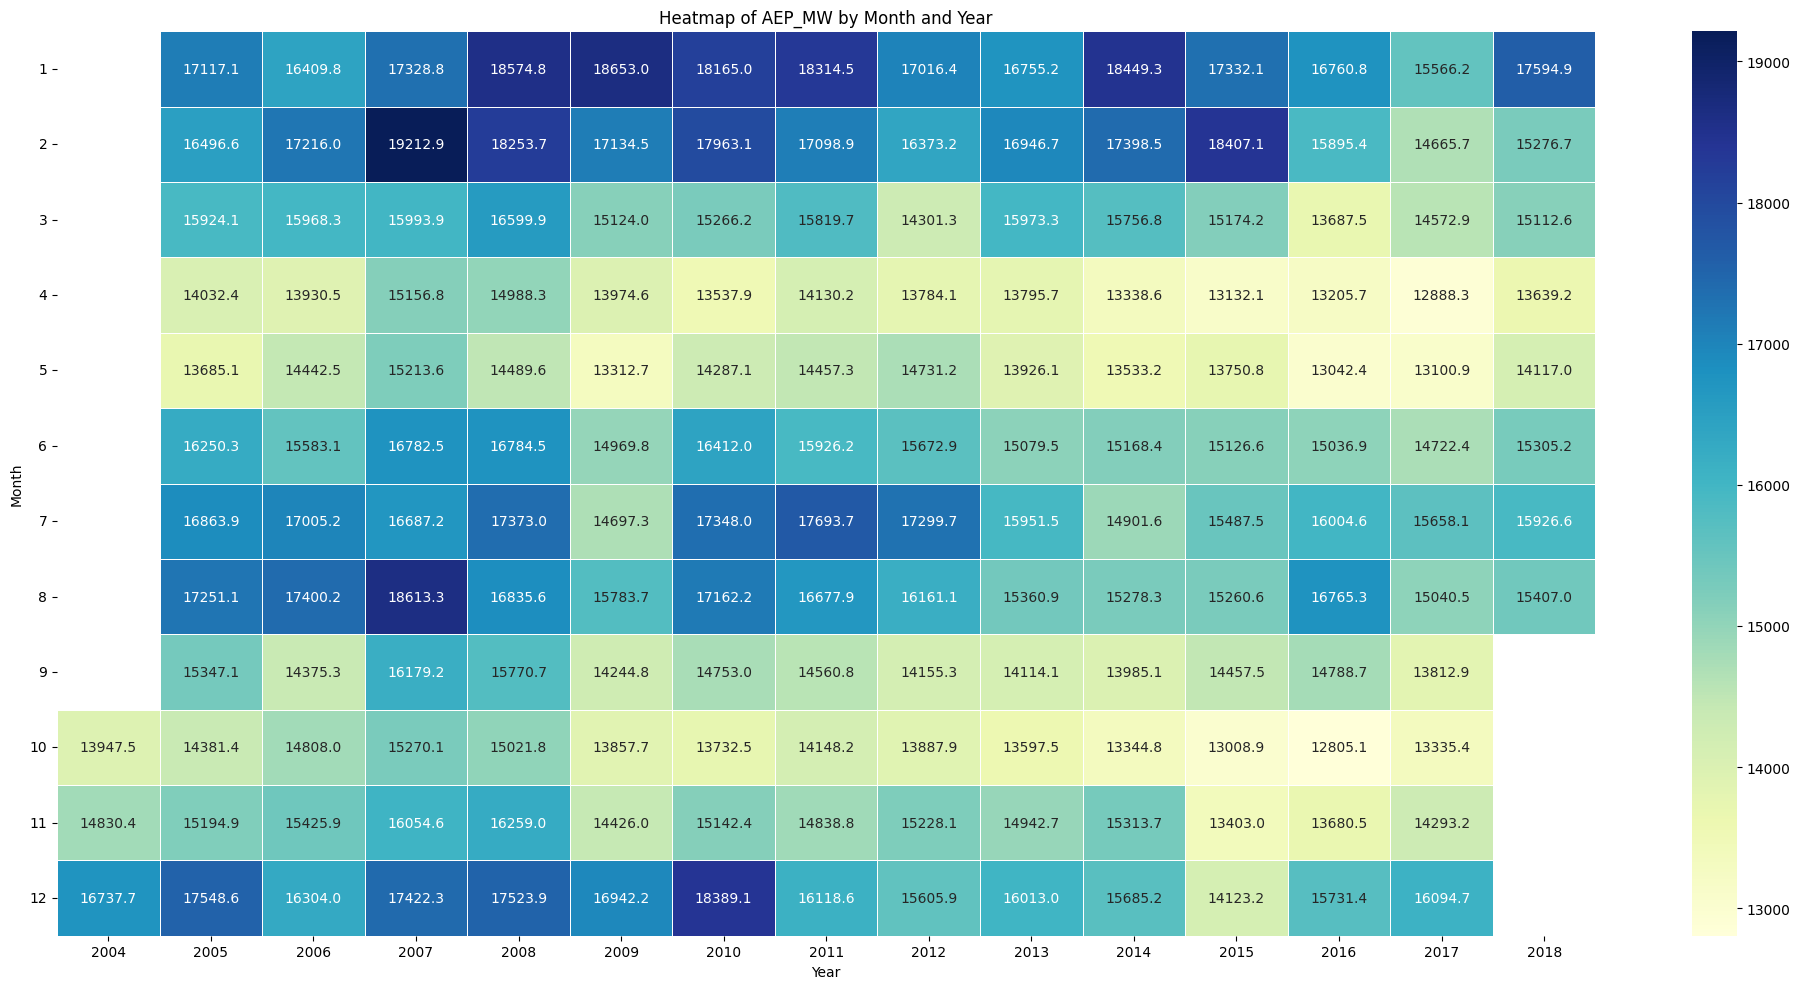

In [9]:
heatmap_data = mean_month.pivot(index='month', columns='year', values='AEP_MW').round(2)
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of AEP_MW by Month and Year")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

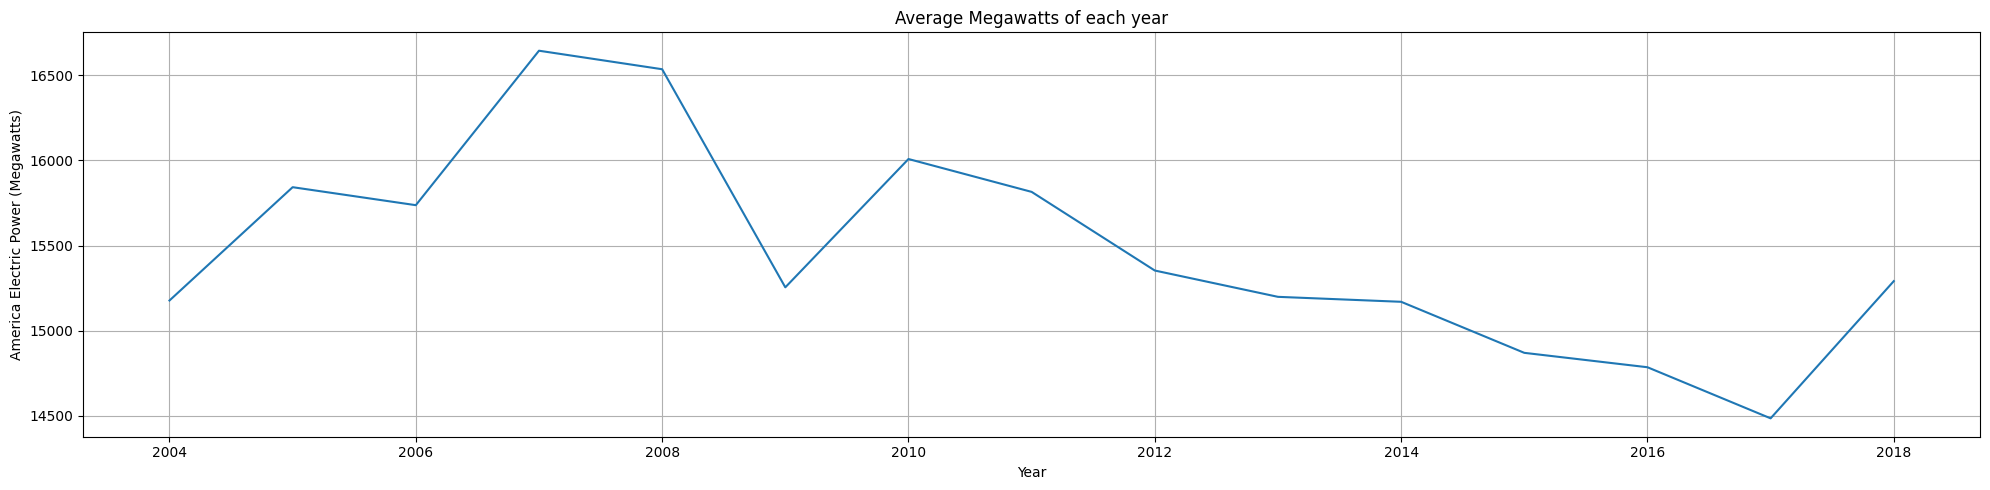

In [10]:
mean_year = american_electric_power.groupby(["year"])["AEP_MW"].mean().reset_index()
plt.figure(figsize = (20, 5))
sns.lineplot(data = mean_year, x = "year", y = "AEP_MW")
plt.title("Average Megawatts of each year")
plt.xlabel("Year")
plt.ylabel("America Electric Power (Megawatts)")
plt.grid(True)
plt.tight_layout()
plt.show()

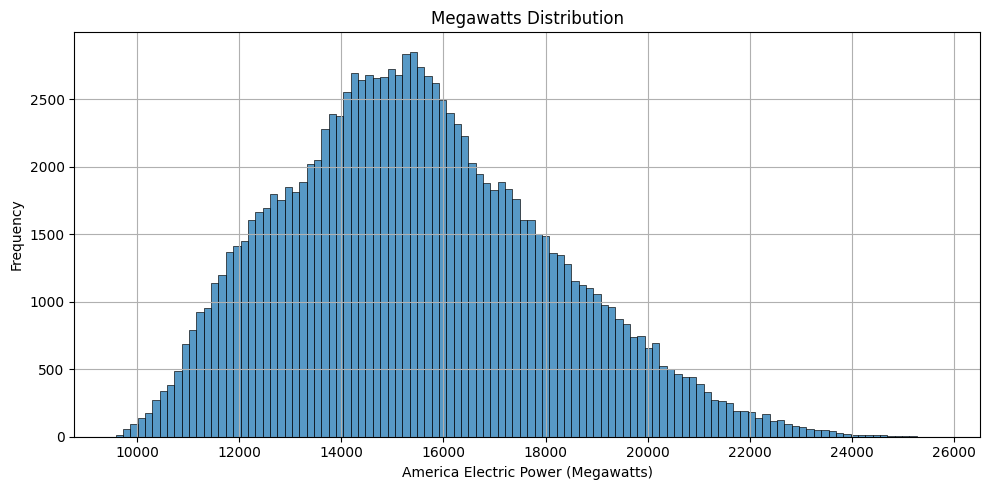

In [11]:
plt.figure(figsize = (10, 5))
sns.histplot(data = american_electric_power, x="AEP_MW")
plt.title("Megawatts Distribution")
plt.xlabel("America Electric Power (Megawatts)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

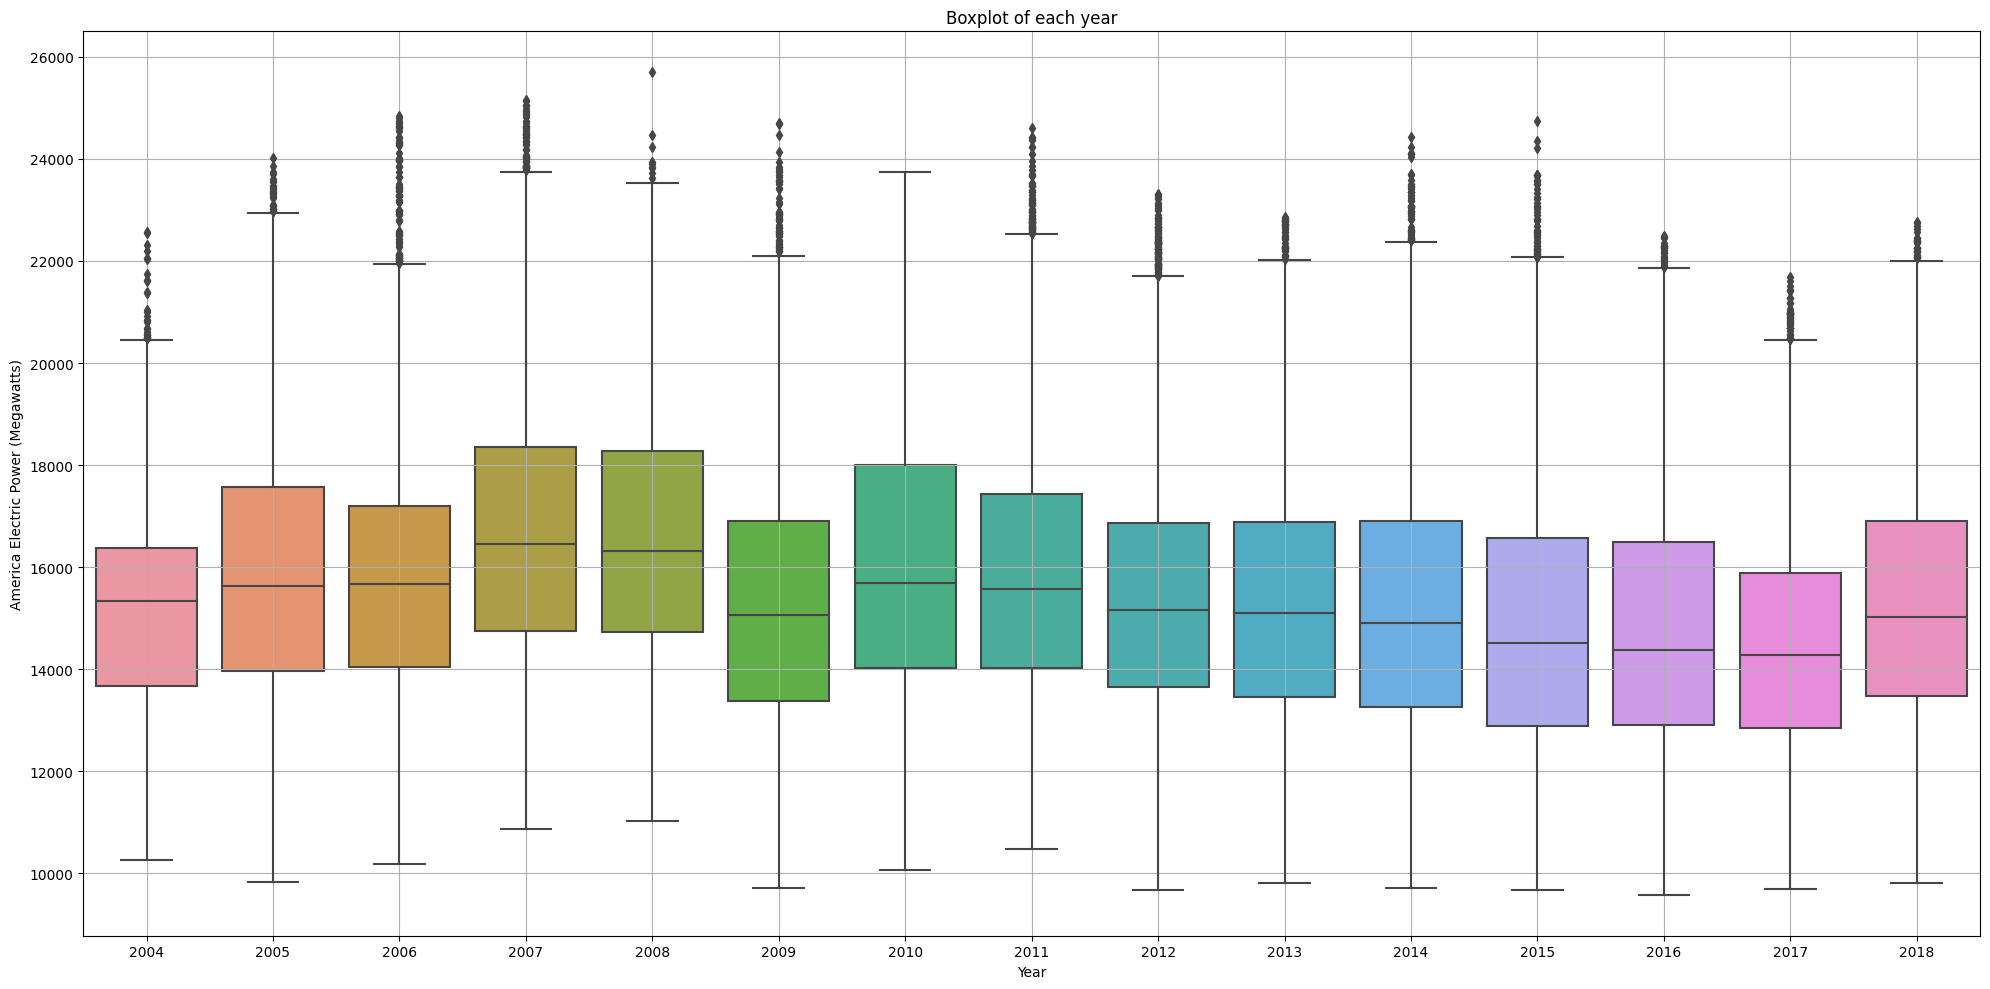

In [12]:
plt.figure(figsize = (20, 10))
sns.boxplot(data = american_electric_power, x = "year", y = "AEP_MW")
plt.title("Boxplot of each year")
plt.xlabel("Year")
plt.ylabel("America Electric Power (Megawatts)")
plt.grid(True)
plt.tight_layout()
plt.show()

# WindowGenerator

In [70]:
n = len(american_electric_power)
train_df = american_electric_power.drop(columns = ['Datetime'])[0:int(n*0.7)]
val_df = american_electric_power.drop(columns = ['Datetime'])[int(n*0.7):int(n*0.9)]
test_df = american_electric_power.drop(columns = ['Datetime'])[int(n*0.9):]

In [133]:
class WindowGenerator:

    def __init__(self, input_width, label_width, shift,
                train_df = None, val_df = None, test_df = None, label_columns = None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
        
    WindowGenerator.split_window = split_window

    def plot(self, model=None, plot_col='AEP_MW', max_subplots=3):
        inputs, labels = self.example[0], self.example[1]
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
    
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
    
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
    
            if label_col_index is None:
                continue
    
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
    
            if n == 0:
                plt.legend()
    
        plt.xlabel('Time [h]')

    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
    
      ds = ds.map(self.split_window)
    
      return ds
    
    WindowGenerator.make_dataset = make_dataset
    
    @property
    def train(self):
      return self.make_dataset(self.train_df)
    
    @property
    def val(self):
      return self.make_dataset(self.val_df)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df)
    
    @property
    def example(self):
      result = getattr(self, '_example', None)
      if result is None:
        result = next(iter(self.train))
        self._example = result
      return result
    
    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example

In [134]:
w1 = WindowGenerator(input_width = 6, label_width = 1, shift = 1,
                    train_df = train_df, val_df = val_df, test_df = test_df,
                    label_columns = ['AEP_MW'])
print(w1)

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['AEP_MW']


In [135]:
w2 = WindowGenerator(input_width = 24, label_width = 1, shift = 24,
                    train_df = train_df, val_df = val_df, test_df = test_df,
                    label_columns = ['AEP_MW'])
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['AEP_MW']


In [136]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                         np.array(train_df[100 : 100 + w1.total_window_size]),
                         np.array(train_df[100 : 100 + w1.total_window_size])
                        ])

example_inputs, example_labels = w1.split_window(example_window)
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

Window shape: (3, 7, 4)
Inputs shape: (3, 6, 4)
labels shape: (3, 1, 1)


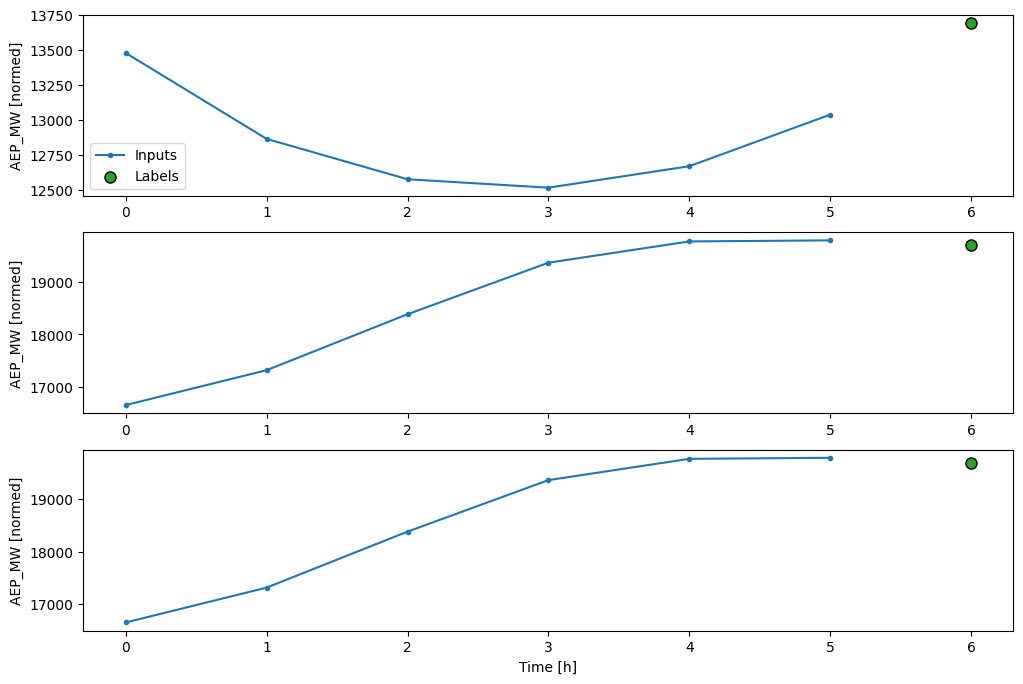

In [142]:
w1._example = example_inputs, example_labels
WindowGenerator.plot = plot
w1.plot(plot_col='AEP_MW')

In [143]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [144]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 4)
Labels shape (batch, time, features): (32, 1, 1)
